In [1]:
!pip install keras-octave-conv

     |████████████████████████████████| 110 kB 4.0 MB/s 
  Created wheel for keras-octave-conv: filename=keras_octave_conv-0.10.0-py3-none-any.whl size=12421 sha256=86424bb454b7f16058dff2ea4fa52fe58111fec17bab3bdee8e839da36749f93
  Stored in directory: /root/.cache/pip/wheels/5c/19/6d/440fbd8eaa479680d1f757749f1a0ff94addf07b5d4c49c75e
Successfully built keras-octave-conv


In [2]:
#First Octave
#Use a single input for the first octave layer

In [3]:
from keras.layers import Input
from keras_octave_conv import OctaveConv2D

inputs = Input(shape=(32, 32, 3))
high, low = OctaveConv2D(filters=16, kernel_size=3, octave=2, ratio_out=0.125)(inputs)

In [4]:
#The two outputs represent the results in higher and lower spatial resolutions.

#Special arguments:
#octave: default is 2. The division of the spatial dimensions.
#ratio_out: default is 0.5. The ratio of filters for lower spatial resolution.

In [5]:
#Intermediate Octave
#The intermediate octave layers takes two inputs and produce two outputs:
from keras.layers import Input, MaxPool2D
from keras_octave_conv import OctaveConv2D

inputs = Input(shape=(32, 32, 3))
high, low = OctaveConv2D(filters=16, kernel_size=3)(inputs)

high, low = MaxPool2D()(high), MaxPool2D()(low)
high, low = OctaveConv2D(filters=8, kernel_size=3)([high, low])
#Note that the same octave value should be used throughout the whole model.

In [6]:
#Last Octave
#Set ratio_out to 0.0 to get a single output for further processing:

In [7]:
from keras.layers import Input, MaxPool2D, Flatten, Dense
from keras.models import Model
from keras_octave_conv import OctaveConv2D

inputs = Input(shape=(32, 32, 3))
high, low = OctaveConv2D(filters=16, kernel_size=3)(inputs)

high, low = MaxPool2D()(high), MaxPool2D()(low)
high, low = OctaveConv2D(filters=8, kernel_size=3)([high, low])

high, low = MaxPool2D()(high), MaxPool2D()(low)
conv = OctaveConv2D(filters=4, kernel_size=3, ratio_out=0.0)([high, low])

flatten = Flatten()(conv)
outputs = Dense(units=10, activation='softmax')(flatten)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
octave_conv2d_3 (OctaveConv2D)  [(None, 32, 32, 8),  448         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 8)    0           octave_conv2d_3[0][0]            
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 8)      0           octave_conv2d_3[0][1]            
______________________________________________________________________________________________

In [8]:
#Utility
#octave_dual helps to create dual layers for processing the outputs of octave convolutions:

In [9]:
from keras.layers import Input, MaxPool2D, Flatten, Dense
from keras.models import Model
from keras_octave_conv import OctaveConv2D, octave_dual

inputs = Input(shape=(32, 32, 3))
conv = OctaveConv2D(filters=16, kernel_size=3)(inputs)

pool = octave_dual(conv, MaxPool2D())
conv = OctaveConv2D(filters=8, kernel_size=3)(pool)

pool = octave_dual(conv, MaxPool2D())
conv = OctaveConv2D(filters=4, kernel_size=3, ratio_out=0.0)(pool)

flatten = Flatten()(conv)
outputs = Dense(units=10, activation='softmax')(flatten)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
octave_conv2d_6 (OctaveConv2D)  [(None, 32, 32, 8),  448         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6-H (MaxPooling2D (None, 16, 16, 8)    0           octave_conv2d_6[0][0]            
__________________________________________________________________________________________________
max_pooling2d_6-L (MaxPooling2D (None, 8, 8, 8)      0           octave_conv2d_6[0][1]            
____________________________________________________________________________________________

In [10]:
#octave_conv_2d creates the octave structure with built-in Keras layers:

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Octave-First-HH (Conv2D)        (None, 32, 32, 8)    224         Input[0][0]                      
__________________________________________________________________________________________________
Octave-First-Pool (AveragePooli (None, 16, 16, 3)    0           Input[0][0]                      
__________________________________________________________________________________________________
Pool-1-H (MaxPooling2D)         (None, 16, 16, 8)    0           Octave-First-HH[0][0]            
____________________________________________________________________________________________

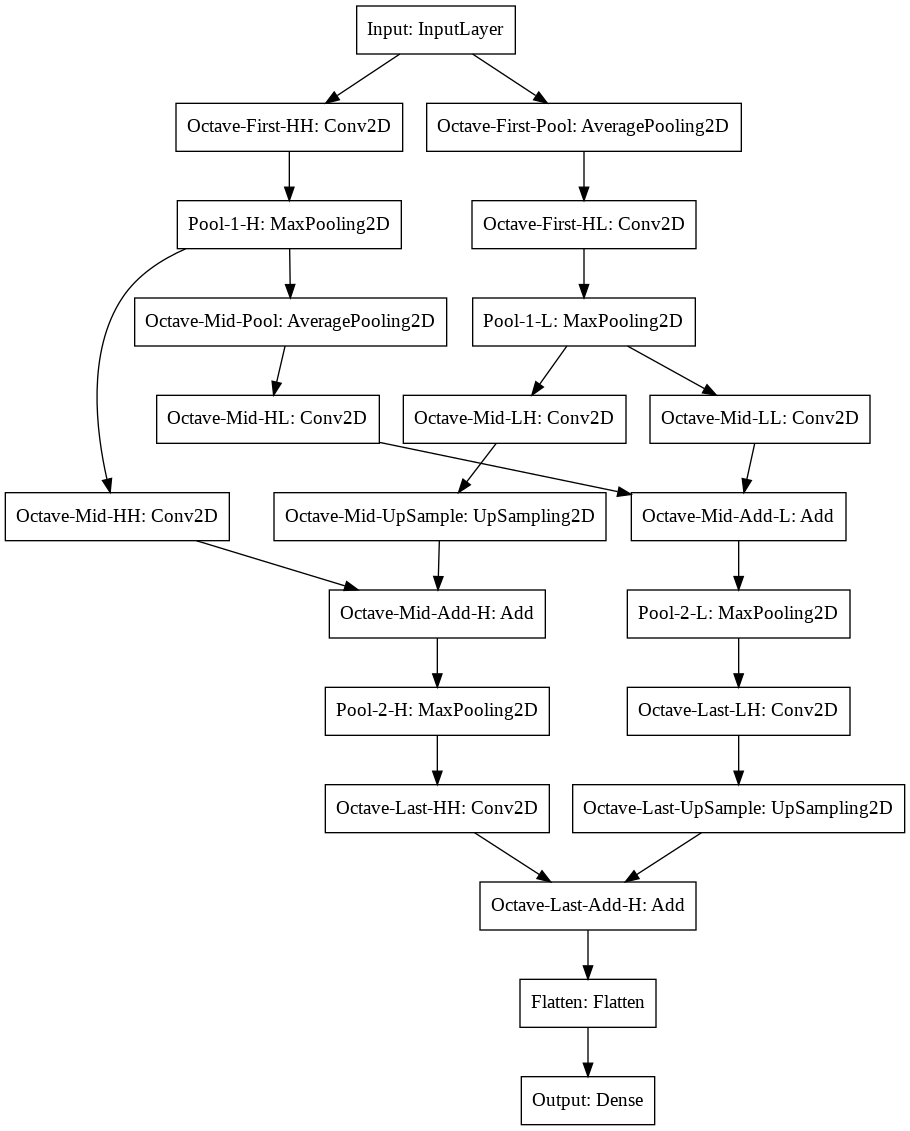

In [11]:
from keras.layers import Input, MaxPool2D, Flatten, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras_octave_conv import octave_conv_2d, octave_dual

inputs = Input(shape=(32, 32, 3), name='Input')
conv = octave_conv_2d(inputs, filters=16, kernel_size=3, name='Octave-First')

pool = octave_dual(conv, MaxPool2D(name='Pool-1'))
conv = octave_conv_2d(pool, filters=8, kernel_size=3, name='Octave-Mid')

pool = octave_dual(conv, MaxPool2D(name='Pool-2'))
conv = octave_conv_2d(pool, filters=4, kernel_size=3, ratio_out=0.0, name='Octave-Last')

flatten = Flatten(name='Flatten')(conv)
outputs = Dense(units=10, activation='softmax', name='Output')(flatten)

model = Model(inputs=inputs, outputs=outputs)
model.summary()
plot_model(model, to_file='octave_model.png')